# Лекция 18. Numba

## [Numba](http://numba.pydata.org/)

`Numba` is an open source JIT compiler that translates a subset of `Python` and `NumPy` code into fast machine code

`Numba` - это:
- компиляция во время выполнения, just-in-time compilation (JIT)
- компиляция для CPU и GPU
- автоматическое распараллеливание [OpenMP](https://en.wikipedia.org/wiki/OpenMP) and [SIMD](https://en.wikipedia.org/wiki/SIMD)
- кросс-платформенность
- кэширование компилированного кода
- компиляция заранее, ahead-of-time compilation (AOT)

### Как работает `Numba`:

функция `Python` $\rightarrow$ первый вызов функции $\rightarrow$ подстановка типов аргументов при первом вызове $\rightarrow$ промежуточное представление (IR) $\rightarrow$ компилятор [LLVM](https://llvm.org/) или компилятор [NVCC](https://en.wikipedia.org/wiki/Nvidia_CUDA_Compiler) $\rightarrow$ компилированная функция (машинный код CPU/GPU)

### Что мы будем использовать из модуля `Numba`:

- `@jit, @njit` - для компиляции основных функций
- `prange` - для распараллеливания

### Использование декоратора `@jit`


Замечание:

`njit` $\equiv$ `jit(nopython=True)`

Декоратор без параметров
```
@jit
def my_func():
    # тело функции
```

Декоратор с параметрами
```
@jit(signature, nopython=True, cache=True, fastmath=True, boundscheck=False, ...)
def my_func():
    # тело функции
```

- `signature` - сигнатура или объявление функции, которое содержит тип возращаемого значения и типы всех аргументов

- `nopython = True` - компилировать в режиме nopython (этот режим мы будем использовать)

- `cache = True` - кэшировать компилированный код (работает только для функций, код которых записан в `*.py` файле)

- `fastmath = True` - оптимизировать некоторые математические операции; может ускорить вычисления, но некоторые операции могут выполняться с повышенной погрешностью

- `boundscheck = False` - отключить проверку выхода за границы массива (можно применять, если грамотно написаны циклы, либо использованы операции `Numpy`)


### Как писать код, чтобы получить быструю функцию с применением `jit`?

Простые правила, т.е. так сработает. Можно и по-другому, но это сложнее.

- Параметры `jit`
 - `nopython = True`, либо использование `njit`


- Типы аргументов:
    - числовые константы, True/False, None
    - массивы `Numpy`
    - именованные аргументы со значением по-умолчанию 
    - callback-функции (на данный момент `Numba` поддерживает только в экспериментальном режиме)
    
    
- Возвращаемое значение:
    - числовые константы, True/False
    - массивы `Numpy`
    - кортежи
    
    
- Тело функции:
    - арифметические выражения
    - ветвления
    - циклы `Python`
    - поддерживаемые функции и выражения `Numpy`
    - вызовы других `jit`-функций

In [1]:
!pip install numpy matplotlib numba

In [2]:
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange

### Построение изображения [множества Мандельброта](https://ru.wikipedia.org/wiki/Множество_Мандельброта)

Множество Мандельброта - множество точек $c$ комплексной плоскости, для которых рекуррентное соотношение $z_{n+1} = z_n^2 + c$ при $z_0 = 0$ задает ограниченную последовательность.

Цель расчета: построить изображение $16000 x 8000$ пикселей при максимальном количестве итераций рекуррентной формулы в $1000$

In [4]:
nx, ny = 200, 100
nx_full, ny_full = 16000, 8000

x_min, x_max = -1.5, 0.5
y_min, y_max = 0.0, 1.0

k = nx_full * ny_full / (nx * ny)
k

6400.0

### Прототип

In [6]:
def escape_proto(c, maxit=1000):
    z = 0
    for i in range(maxit):
        z = z**2 + c
        if abs(z) > 2:
            break
    return i

In [7]:
def mandelbrot_proto(x_min, x_max, y_min, y_max, nx, ny, maxit=1000):
    dx = (x_max - x_min) / nx
    dy = (y_max - y_min) / ny
    
    res = []
    for iy in range(ny):
        res.append([])
        for ix in range(nx):
            x = x_min + dx * ix
            y = y_min + dy * iy
            c = complex(x, y) #x + 1j * y
            it = escape_proto(c, maxit)
            res[-1].append(it)
    return res

In [8]:
res_proto = mandelbrot_proto(x_min, x_max, y_min, y_max, nx, ny)

In [11]:
t_proto = timeit("mandelbrot_proto(x_min, x_max, y_min, y_max, nx, ny)",
                 number = 1, globals = globals())
t_proto

2.5333312999937334

In [13]:
t_proto * k // 60

270.0

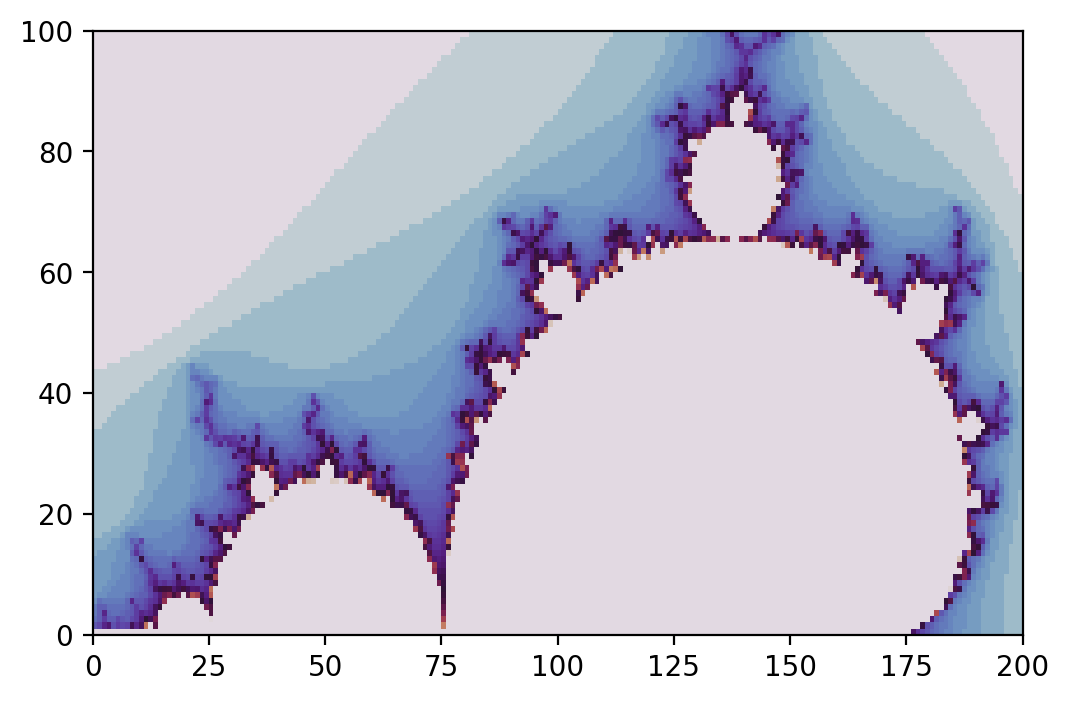

In [18]:
plt.figure(dpi=200)
plt.pcolormesh(np.log(np.array(res_proto)), cmap='twilight')

### Компиляция кода для одного ядра

- Использовать декоратор `@jit(nopython = True)` или `@njit`

- Переписать код для работы с массивами вместо списков

In [28]:
@njit(fastmath=True)
def escape_njit(c, maxit=1000):
    z = 0
    for i in range(maxit):
        z = z**2 + c
        if abs(z) > 2:
            break
    return i

In [29]:
@njit(fastmath=True)
def mandelbrot_njit(x_min, x_max, y_min, y_max, nx, ny, maxit=1000):
    dx = (x_max - x_min) / nx
    dy = (y_max - y_min) / ny
    
    res = np.empty((ny, nx), dtype=np.uint16)
    for iy in range(ny):
        for ix in range(nx):
            x = x_min + dx * ix
            y = y_min + dy * iy
            c = complex(x, y) #x + 1j * y
            it = escape_njit(c, maxit)
            res[iy, ix] = it
    return res

In [30]:
mandelbrot_njit(x_min, x_max, y_min, y_max, 1, 1)

array([[999]], dtype=uint16)

In [31]:
res_njit = mandelbrot_njit(x_min, x_max, y_min, y_max, nx, ny)

In [32]:
n = 100
t_njit = timeit("mandelbrot_njit(x_min, x_max, y_min, y_max, nx, ny)",
                 number = n, globals = globals()) / n
t_njit 

0.047113069000042744

In [33]:
t_njit * k // 60

5.0

In [34]:
np.all(res_njit == np.array(res_proto))

False

In [35]:
np.where(res_njit != np.array(res_proto))

(array([55, 63], dtype=int64), array([ 95, 115], dtype=int64))

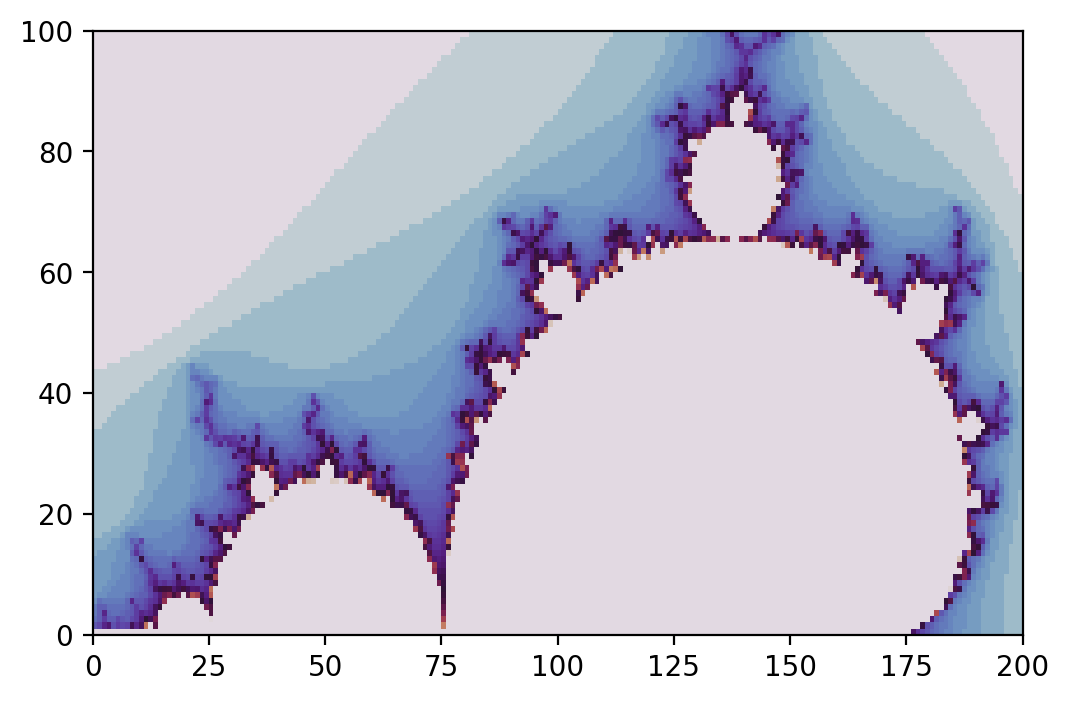

In [27]:
plt.figure(dpi=200)
plt.pcolormesh(np.log(res_njit), cmap='twilight')

### Распараллеливание в Numba

- Декоратор `jit`/`njit` должен быть снабжен аргументом `parallel = True`

- Во внешнем цикле вместо `range` необходимо использовать `prange`

In [37]:
@njit(fastmath=True, parallel=True)
def mandelbrot_par(x_min, x_max, y_min, y_max, nx, ny, maxit=1000):
    dx = (x_max - x_min) / nx
    dy = (y_max - y_min) / ny
    
    res = np.empty((ny, nx), dtype=np.uint16)
    for iy in prange(ny):
        for ix in range(nx):
            x = x_min + dx * ix
            y = y_min + dy * iy
            c = complex(x, y) #x + 1j * y
            it = escape_njit(c, maxit)
            res[iy, ix] = it
    return res

In [38]:
mandelbrot_par(x_min, x_max, y_min, y_max, 1, 1)

array([[999]], dtype=uint16)

In [39]:
res_par = mandelbrot_par(x_min, x_max, y_min, y_max, nx, ny)

In [40]:
n = 100
t_par = timeit("mandelbrot_par(x_min, x_max, y_min, y_max, nx, ny)",
                 number = n, globals = globals()) / n
t_par 

0.016829275999989478

In [41]:
t_par * k // 60

1.0

In [42]:
res_full = mandelbrot_par(x_min, x_max, y_min, y_max, nx_full, ny_full)

In [43]:
res_full.shape

(8000, 16000)

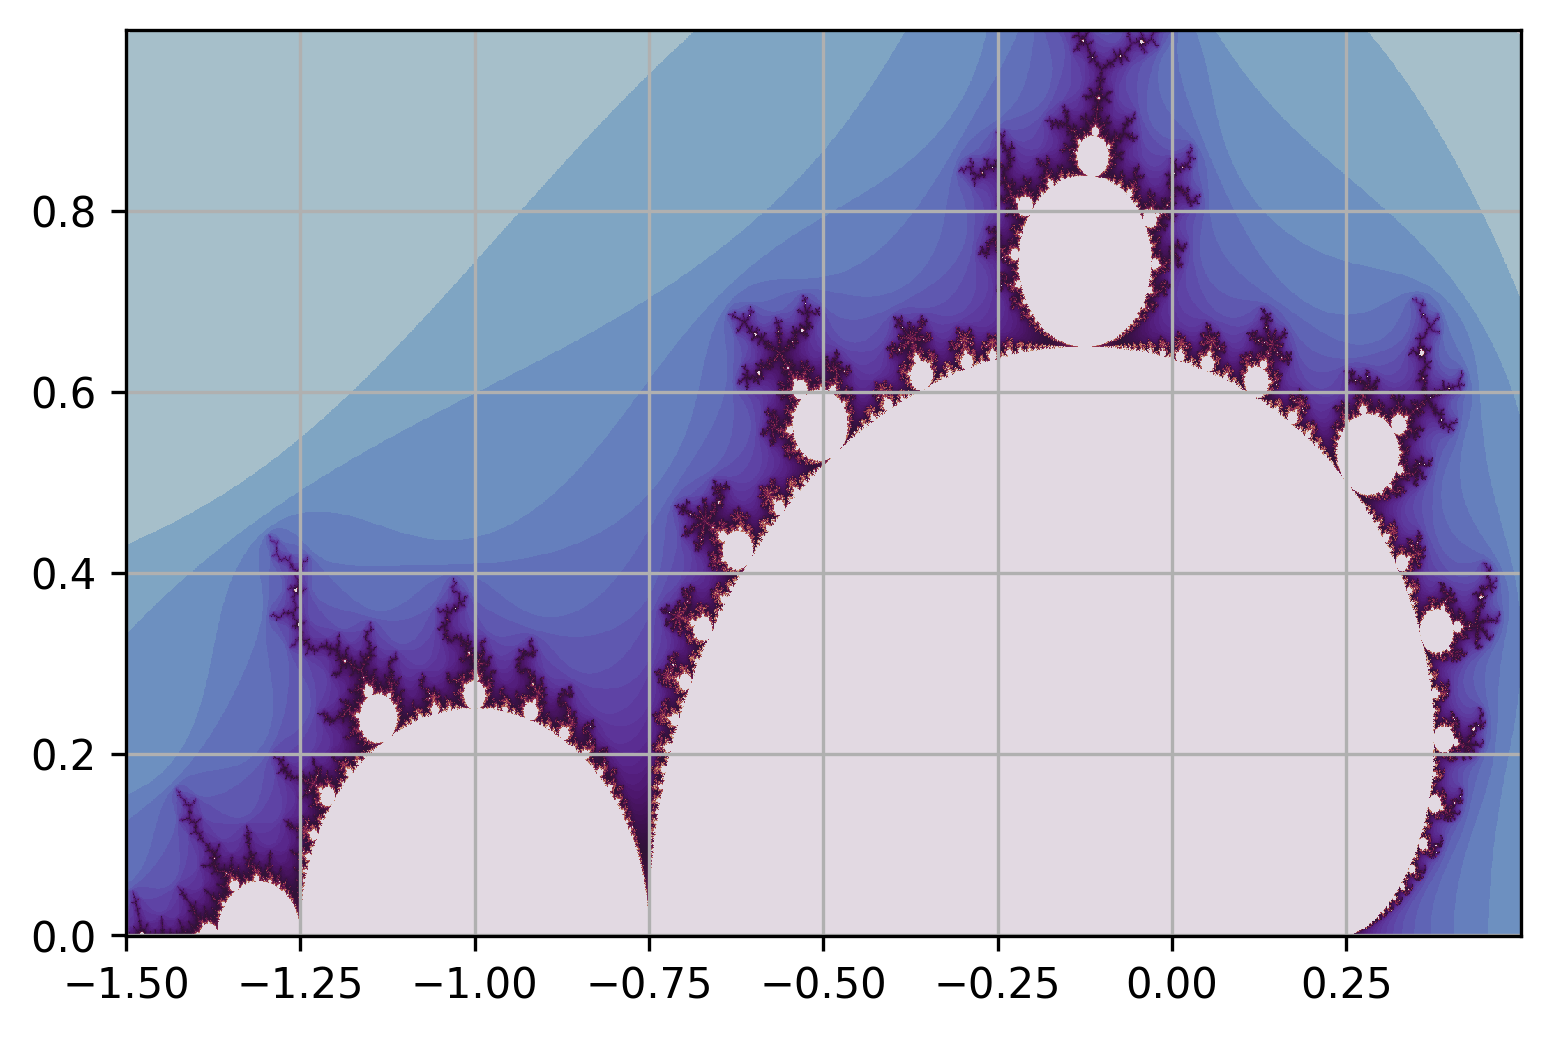

In [51]:
plt.figure(dpi=300)
x = np.linspace(x_min, x_max, nx_full)
y = np.linspace(y_min, y_max, ny_full)

plt.pcolormesh(x[::8], y[::8], np.log(res_full[::8, ::8]), cmap='twilight', shading='auto')
plt.grid();
#plt.axis('equal');

In [ ]:
# Задание
# resolution 2000, 1000
# x [-0.25, 0.0]
# y [0.8, 1.0]


In [64]:
@njit(fastmath=True)
def escape_njit(c, maxit=1000):
    z = 0
    for i in range(maxit):
        z = z**4 + z**2 + c
        if abs(z) > 2:
            break
    return i

@njit(fastmath=True, parallel=True)
def mandelbrot_par(x_min, x_max, y_min, y_max, nx, ny, maxit=1000):
    dx = (x_max - x_min) / nx
    dy = (y_max - y_min) / ny
    
    res = np.empty((ny, nx), dtype=np.uint16)
    for iy in prange(ny):
        for ix in range(nx):
            x = x_min + dx * ix
            y = y_min + dy * iy
            c = complex(x, y) #x + 1j * y
            it = escape_njit(c, maxit)
            res[iy, ix] = it
    return res

In [68]:
nx, ny = 2000, 1000
x_min, x_max = -1., 1.
y_min, y_max = 0., 1.5

In [69]:
res_par = mandelbrot_par(x_min, x_max, y_min, y_max, nx, ny)

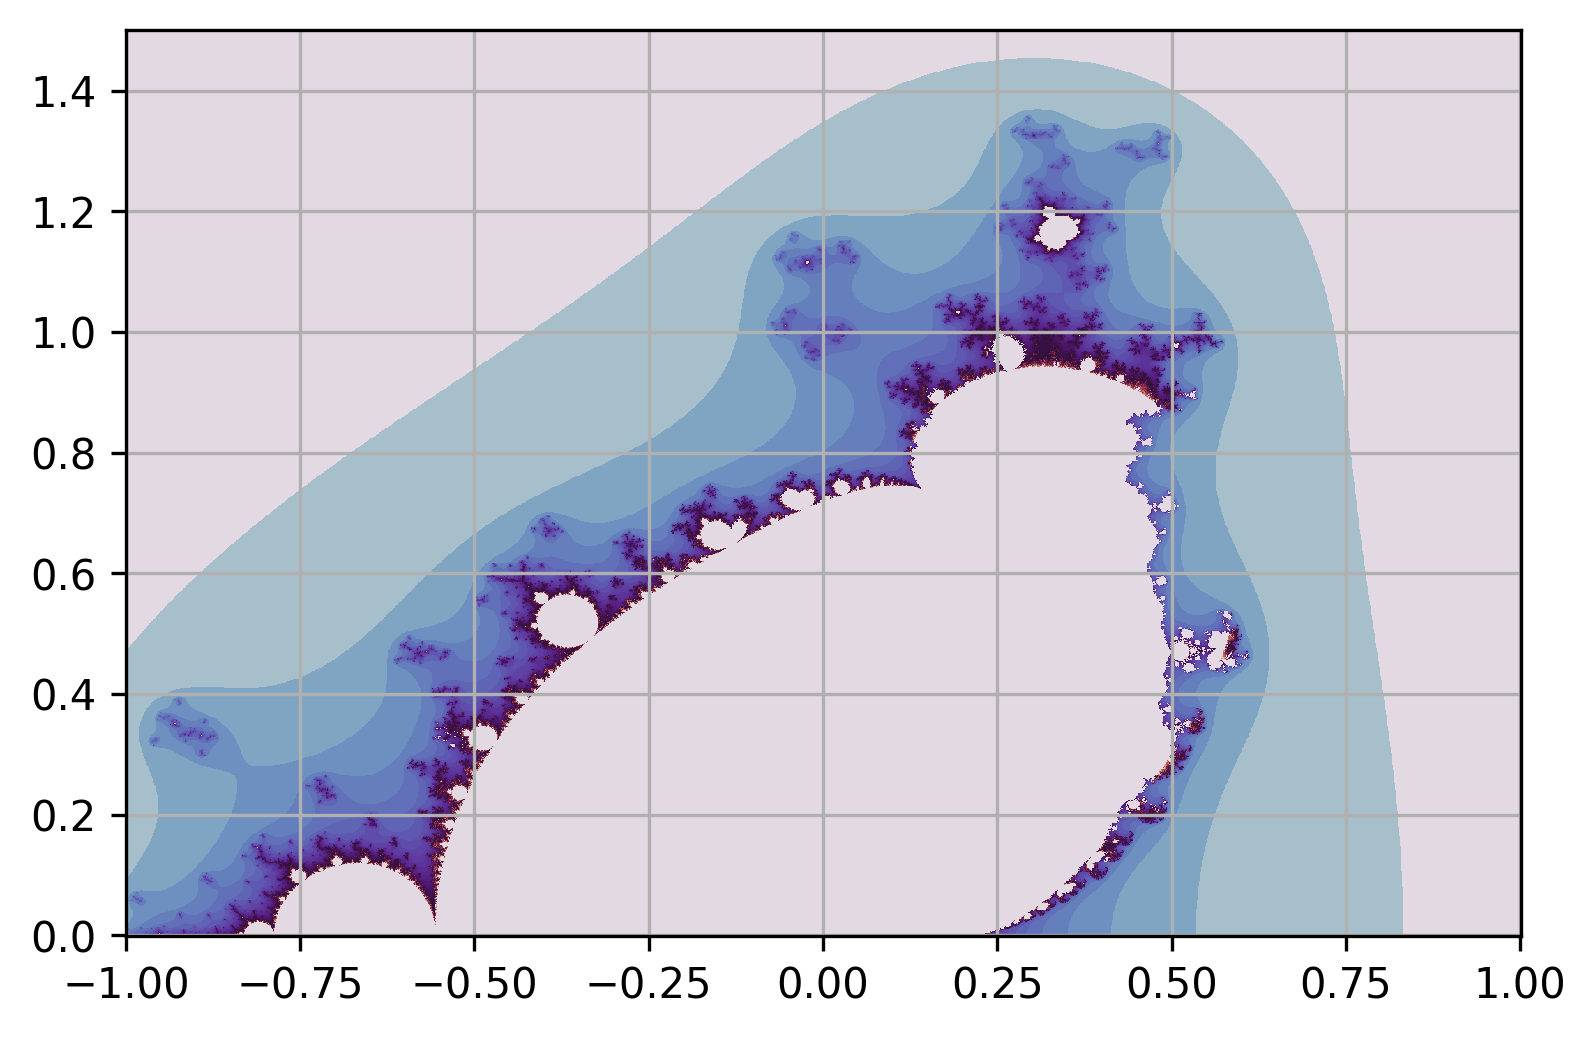

In [70]:
plt.figure(dpi=300)
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

plt.pcolormesh(x, y, np.log(res_par), cmap='twilight', shading='auto')
plt.grid();